In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/output.csv', index_col='Unnamed: 0')

## Preprocessing

Under normal circumstances, I would use a pipeline to clean up this code. However, using a pipeline in conjunction with evaluation or validation metrics for neural networks is difficult in regards to syntax. Thus, I'd rather preprocess outside of a pipeline.

In [3]:
# X / y definition
X = df.drop(columns=['label'])
y = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# SMOTE to address class imbalance (94/6)
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# MinMaxScaler to address features with skewed distributions and different scales
mms = MinMaxScaler()
Xs_train = mms.fit_transform(X_train_sm)
Xs_test = mms.transform(X_test)

# PCA to address multi-collinearity
pca = PCA(
    n_components=8, 
    random_state=42)

pca.fit(Xs_train)

Z_train = pca.transform(Xs_train)
Z_test = pca.transform(Xs_test)

## NN / Modeling - No Regularization or Earlystopping (For testing and demonstration purposes)

In [4]:
# Referred to an architecture similar to attached research paper
# https://arxiv.org/pdf/1807.07282.pdf

model = Sequential()

model.add(Dense(7, input_dim=Z_train.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [5]:
history = model.fit(
    Z_train,
    y_train_sm,
    validation_data=(Z_test, y_test),
    epochs=100,
    batch_size=8000,
    verbose=0
)

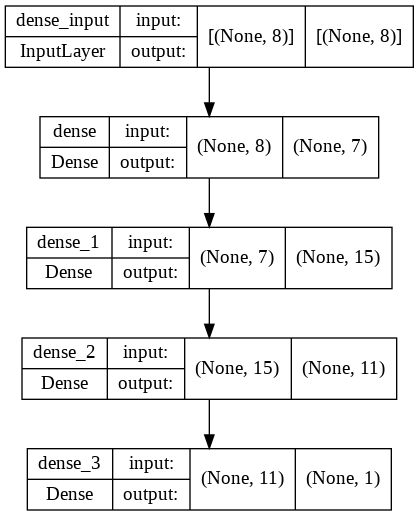

In [6]:
# Model visualization
plot_model(model, show_shapes=True, show_layer_names=True)

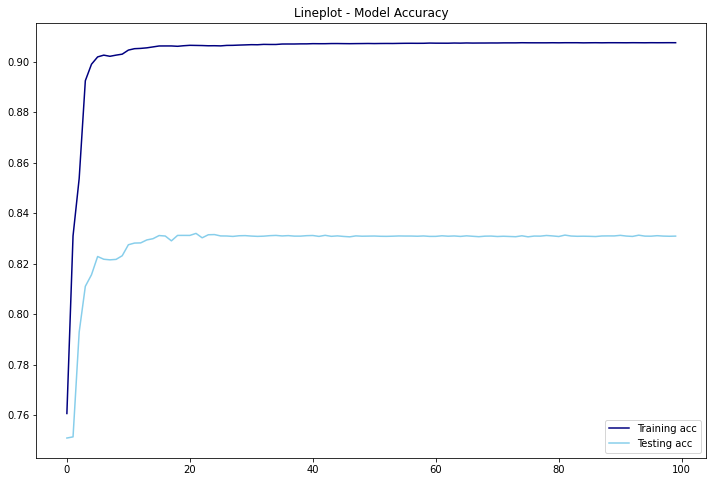

In [7]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']

plt.figure(figsize=(12, 8))
plt.title('Lineplot - Model Accuracy')
plt.plot(train_acc, label='Training acc', color='navy')
plt.plot(test_acc, label='Testing acc', color='skyblue')
plt.legend();

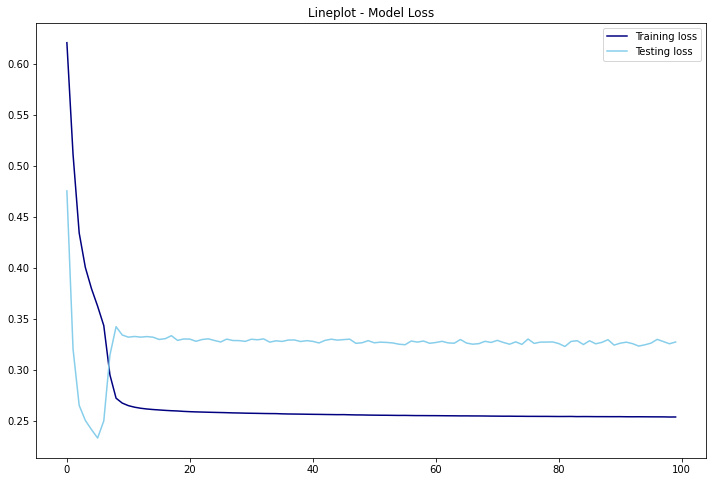

In [8]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.title('Lineplot - Model Loss')
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [9]:
y_preds = (model.predict(Z_test) > 0.5).astype(int)

In [10]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    104230
           1       0.27      0.99      0.43      7016

    accuracy                           0.83    111246
   macro avg       0.64      0.91      0.66    111246
weighted avg       0.95      0.83      0.87    111246



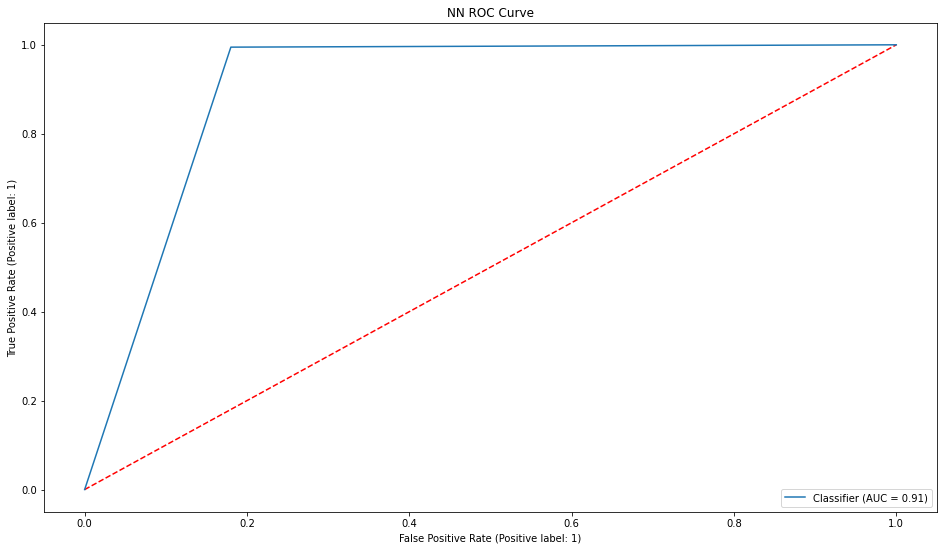

In [11]:
_, ax = plt.subplots(figsize=(16, 9))
ax.title.set_text('NN ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test, y_preds, ax=ax);

Regularization and earlystopping may not have heavily affected the results of the model's performance, but it is more optimal to improve loss, to bridge the gap between training and testing data, as well as conserving computational resources and saving time.